In [1]:
# import rcParams and set the figure size
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# import KMeans from sklearn
from sklearn.cluster import KMeans

## for data
import numpy as np
import pandas as pd
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for geospatial
import folium
import geopy
## for machine learning
from sklearn import preprocessing, cluster
import scipy
## for deep learning
import minisom


In [2]:
# read the data
df_housing = pd.read_csv("ToDo.csv")

# print first five rows of data
df_housing.head()

,collection_sno,benid,stage,creationtime,status,app,observer_name,deviceid,lat,long
0,4775416,031514123NG623820,Below Basement Level (BBL),12/8/2016 11:59,1,1.7,G APPALANAIDU,AE034101,17.504740,82.943947
1,4775415,031514121NG623871,Lintel Level (LL),12/8/2016 12:09,1,1.7,G APPALANAIDU,AE034101,17.455703,82.926953
2,4808796,031514123NG623841,Basement Level (BL),12/19/2016 10:35,1,1.7,G APPALANAIDU,AE034101,17.477330,82.939053
3,4808776,031514123NG623868,Basement Level (BL),12/19/2016 10:58,1,1.7,G APPALANAIDU,AE034101,17.476678,82.939352
4,4808768,031514123NG623820,Basement Level (BL),12/19/2016 11:02,1,1.7,G APPALANAIDU,AE034101,17.462317,82.927637


In [3]:
# check the shape of the data
df_housing.shape

(10000, 10)

In [4]:
# check the data types of the variables
df_housing.dtypes

collection_sno      int64
benid              object
stage              object
creationtime       object
status              int64
app               float64
observer_name      object
deviceid           object
lat               float64
long              float64
dtype: object

In [5]:
# drop unwanted column
df_housing.drop(['creationtime'], axis=1, inplace=True)

In [6]:
df_housing['State'] = 'Andhra Pradesh'
df_housing.head(5)

,collection_sno,benid,stage,status,app,observer_name,deviceid,lat,long,State
0,4775416,031514123NG623820,Below Basement Level (BBL),1,1.7,G APPALANAIDU,AE034101,17.504740,82.943947,Andhra Pradesh
1,4775415,031514121NG623871,Lintel Level (LL),1,1.7,G APPALANAIDU,AE034101,17.455703,82.926953,Andhra Pradesh
2,4808796,031514123NG623841,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.477330,82.939053,Andhra Pradesh
3,4808776,031514123NG623868,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.476678,82.939352,Andhra Pradesh
4,4808768,031514123NG623820,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.462317,82.927637,Andhra Pradesh


In [7]:
df_housing = df_housing.rename(columns={'lat': 'Latitude', 'long': 'Longitude'})
df_housing.head()

,collection_sno,benid,stage,status,app,observer_name,deviceid,Latitude,Longitude,State
0,4775416,031514123NG623820,Below Basement Level (BBL),1,1.7,G APPALANAIDU,AE034101,17.504740,82.943947,Andhra Pradesh
1,4775415,031514121NG623871,Lintel Level (LL),1,1.7,G APPALANAIDU,AE034101,17.455703,82.926953,Andhra Pradesh
2,4808796,031514123NG623841,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.477330,82.939053,Andhra Pradesh
3,4808776,031514123NG623868,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.476678,82.939352,Andhra Pradesh
4,4808768,031514123NG623820,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.462317,82.927637,Andhra Pradesh


In [8]:
city = "vijayawada"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Vijayawada, Vijayawada (Urban), Krishna, Andhra Pradesh, 520001, India
[lat, long]: [16.5087586, 80.6185102]


### Model Building

In [9]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def find_best_k(X, max_k=10, plot=True):
    ## iterations
    distortions = [] 
    for i in range(1, max_k+1):
        if len(X) >= i:
            model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            model.fit(X)
            distortions.append(model.inertia_)

    ## best k: the lowest second derivative
    k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

    ## plot
    if plot is True:
        fig, ax = plt.subplots()
        ax.plot(range(1, len(distortions)+1), distortions)
        ax.axvline(k, ls='--', color="red", label="k = "+str(k))
        ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
        ax.legend()
        ax.grid(True)
        plt.show()
    return k

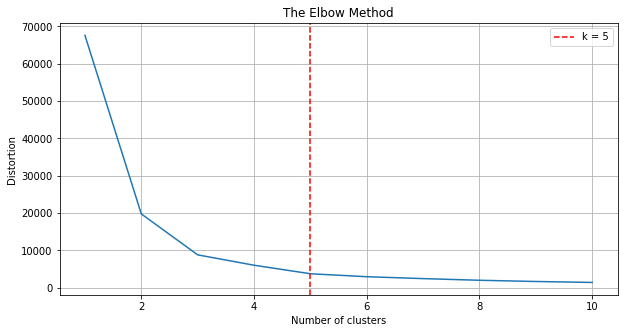

In [10]:
k = find_best_k(df_housing[["Latitude","Longitude"]], max_k=10, plot=True)

In [11]:
model = cluster.KMeans(n_clusters=k, init='k-means++')

In [12]:
def fit_ml_cluster(X, model=None, k=None, lst_2Dplot=None, figsize=(10,5)):
    ## model
    if (model is None) and (k is None):
        model = cluster.AffinityPropagation()
        print("--- k not defined: using Affinity Propagation ---")
    elif (model is None) and (k is not None):
        model = cluster.KMeans(n_clusters=k, init='k-means++')
        print("---", "k="+str(k)+": using k-means ---")

    ## clustering
    dtf_X = X.copy()
    dtf_X["cluster"] = model.fit_predict(X)
    k = dtf_X["cluster"].nunique()
    print("--- found", k, "clusters ---")
    print(dtf_X.groupby("cluster")["cluster"].count().sort_values(ascending=False))

    ## find real centroids
    closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
    dtf_X["centroids"] = 0
    for i in closest:
        dtf_X["centroids"].iloc[i] = 1
    
    ## plot
    if (lst_2Dplot is not None) or (X.shape[1] == 2):
        lst_2Dplot = X.columns.tolist() if lst_2Dplot is None else lst_2Dplot
        th_centroids = model.cluster_centers_ if "KMeans" in str(model) else None
        utils_plot_cluster(dtf_X, x1=lst_2Dplot[0], x2=lst_2Dplot[1], th_centroids=th_centroids, figsize=figsize)

    return model, dtf_X



def utils_plot_cluster(df_housing, x1, x2, th_centroids=None, figsize=(10,5)):
    ## plot points and real centroids
    fig, ax = plt.subplots(figsize=figsize)
    k = df_housing["cluster"].nunique()
    sns.scatterplot(x=x1, y=x2, data=df_housing, palette=sns.color_palette("bright",k),
                        hue='cluster', size="centroids", size_order=[1,0],
                        legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')

    ## plot theoretical centroids
    if th_centroids is not None:
        ax.scatter(th_centroids[:,df_housing.columns.tolist().index(x1)], 
                   th_centroids[:,df_housing.columns.tolist().index(x2)], 
                   s=50, c='black', marker="x")

    ## plot links from points to real centroids
    # if plot_links is True:
    #     centroids_idx = dtf[dtf["centroids"]==1].index
    #     colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    #     for k, col in zip(range(k), colors):
    #         class_members = dtf["cluster"].values == k
    #         cluster_center = dtf[[x1,x2]].values[centroids_idx[k]]
    #         plt.plot(dtf[[x1,x2]].values[class_members, 0], dtf[[x1,x2]].values[class_members, 1], col + '.')
    #         plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    #         for x in dtf[[x1,x2]].values[class_members]:
    #             plt.plot([cluster_center[0], x[0]], 
    #                      [cluster_center[1], x[1]], 
    #                      col)

    ax.grid(True)
    plt.show()

--- found 5 clusters ---
cluster
0    2877
2    2062
3    1881
1    1871
4    1309
Name: cluster, dtype: int64


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


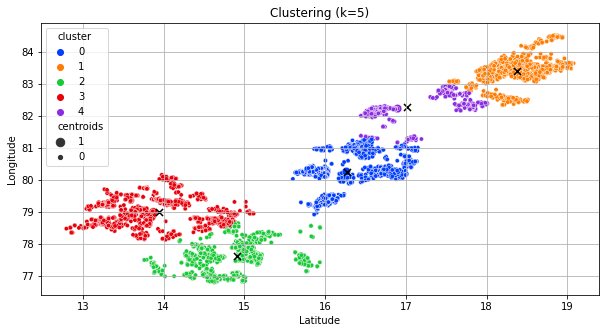

In [13]:
model, dtf_X = fit_ml_cluster(X=df_housing[["Latitude","Longitude"]], model=model, figsize=(10,5))

In [14]:
# consider the variables
X = df_housing[['Latitude', 'Longitude']]

In [15]:
# predict the values
y_predicted = model.fit_predict(X)

In [16]:
# add the new column to the dataframe
df_housing['cluster'] = y_predicted
# display the dataframe
df_housing.head()

,collection_sno,benid,stage,status,app,observer_name,deviceid,Latitude,Longitude,State,cluster
0,4775416,031514123NG623820,Below Basement Level (BBL),1,1.7,G APPALANAIDU,AE034101,17.504740,82.943947,Andhra Pradesh,1
1,4775415,031514121NG623871,Lintel Level (LL),1,1.7,G APPALANAIDU,AE034101,17.455703,82.926953,Andhra Pradesh,1
2,4808796,031514123NG623841,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.477330,82.939053,Andhra Pradesh,1
3,4808776,031514123NG623868,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.476678,82.939352,Andhra Pradesh,1
4,4808768,031514123NG623820,Basement Level (BL),1,1.7,G APPALANAIDU,AE034101,17.462317,82.927637,Andhra Pradesh,1


In [17]:
df_housing['cluster'].value_counts()

2    2868
4    2042
0    1901
3    1876
1    1313
Name: cluster, dtype: int64

In [18]:
df_housing.to_csv("result.csv")

In [19]:
# check the number of clusters
df_housing['cluster'].unique()

array([1, 2, 3, 4, 0], dtype=int32)

In [20]:
# get all the values
X = X.values

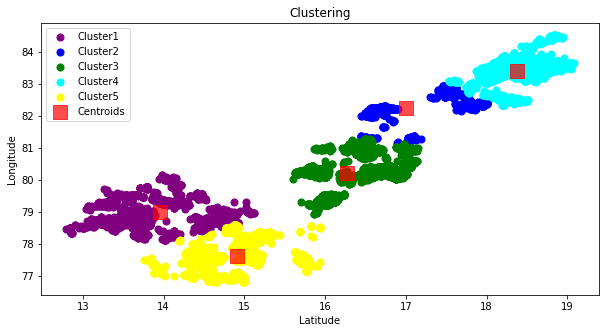

In [21]:
# Visualizing the clusters for k=5
plt.scatter(X[y_predicted==0,0],X[y_predicted==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X[y_predicted==1,0],X[y_predicted==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X[y_predicted==2,0],X[y_predicted==2,1],s=50, c='green',label='Cluster3')
plt.scatter(X[y_predicted==3,0],X[y_predicted==3,1],s=50, c='cyan',label='Cluster4')
plt.scatter(X[y_predicted==4,0],X[y_predicted==4,1],s=50, c='yellow',label='Cluster5')

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [22]:
model.cluster_centers_

array([[13.95984041, 78.98947535],
       [17.00106686, 82.26554616],
       [16.26669442, 80.23052162],
       [18.37521646, 83.40840544],
       [14.90521147, 77.60158265]])

<AxesSubplot:xlabel='cluster', ylabel='count'>

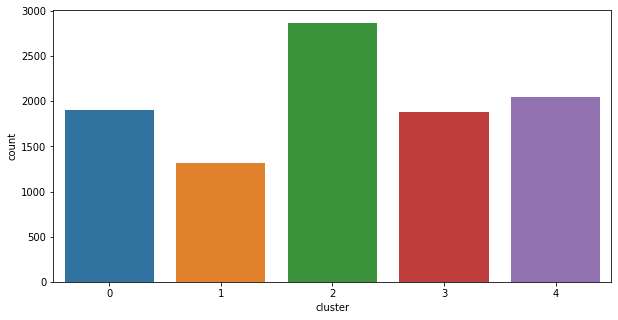

In [23]:
# use 'seaborn' library to plot a barplot for cluster size
sns.countplot(data= df_housing, x = 'cluster')
         

# add values in the graph
#plt.text(x = -0.15, y =6, s = np.unique(model.labels_, return_counts=True)[1][0])
#plt.text(x = 0.8, y =9, s = np.unique(model.labels_, return_counts=True)[1][1])
#plt.text(x = 1.9, y =5, s = np.unique(model.labels_, return_counts=True)[1][2])

#plt.show()

In [24]:
# check the data type of the 'cluster'
df_housing['cluster'].dtypes

dtype('int32')

In [25]:
# change the data type
df_housing = df_housing['cluster'].astype(object)

In [26]:
# serializing our model to a file called model.pkl
import pickle
pickle.dump(model, open("model.pkl","wb"))